In [4]:
for i in range(0,0+1):
    print(i)

0


In [1]:
import torch

In [11]:
vector_a = torch.tensor([11.0, 3.0])
vector_b = torch.tensor([27.0, 7.0]) 
torch.nn.functional.cosine_similarity(vector_a, vector_b, dim=-1)

tensor(0.9999)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

torch.Size([3, 64, 64, 64])
[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
Largest non-zero slice index: 42


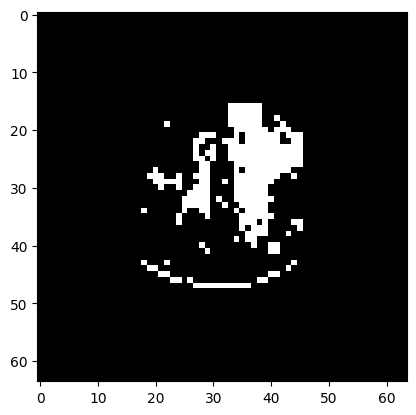

In [31]:
ftv = torch.load("/home/johannes/Data/SSD_2.0TB/GNN_pCR/data/breast_cancer/data_processed/ISPY2-100899/ISPY2-100899-T0_2002-10-26_pCR_0.pt")[0, -1]

img = torch.load("/home/johannes/Data/SSD_2.0TB/GNN_pCR/data/breast_cancer/data_processed/ISPY2-100899/ISPY2-100899-T0_2002-10-26_pCR_0.pt")[0]
print(img.shape)

# get biggest slice of non-zero area in z-direction
non_zero_slices = [i for i in range(ftv.shape[0]) if ftv[i,:,:].sum() > 0]
print(non_zero_slices)
largest_slice = max(non_zero_slices, key=lambda i: ftv[i,:,:].sum())
print("Largest non-zero slice index:", largest_slice)

plt.imshow(ftv[largest_slice,:,:].numpy(), cmap='gray')

In [41]:
early_ce = np.expand_dims(img[0][largest_slice,:,:].numpy(), axis=-1)  
late_ce = np.expand_dims(img[1][largest_slice,:,:].numpy(), axis=-1)
ftv_slice = np.expand_dims(img[2][largest_slice,:,:].numpy(), axis=-1)  

img_2d = np.concatenate((early_ce, late_ce, ftv_slice), axis=-1)
print(img_2d.shape)  # Should be (H, W, 3)


(64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5676391..3.057962].


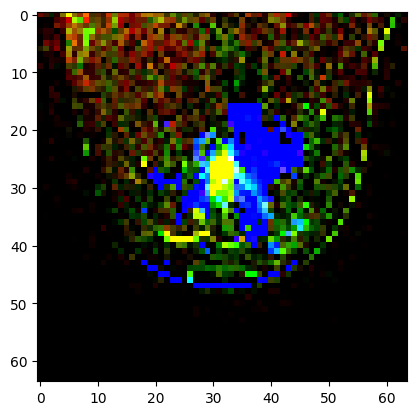

In [42]:
plt.imshow(img_2d, cmap='gray')

In [10]:
class LabelDifference(nn.Module):
    def __init__(self, distance_type='l1'):
        super(LabelDifference, self).__init__()
        self.distance_type = distance_type

    def forward(self, labels):
        # labels: [bs, label_dim]
        # output: [bs, bs]
        if self.distance_type == 'l1':
            return torch.abs(labels[:, None, :] - labels[None, :, :]).sum(dim=-1)
        else:
            raise ValueError(self.distance_type)

class FeatureSimilarity(nn.Module):
    def __init__(self, similarity_type='l2'):
        super(FeatureSimilarity, self).__init__()
        self.similarity_type = similarity_type

    def forward(self, features):
        # labels: [bs, feat_dim]
        # output: [bs, bs]
        if self.similarity_type == 'l2':
            return - (features[:, None, :] - features[None, :, :]).norm(2, dim=-1)
        elif self.similarity_type == 'cosine':
            return F.cosine_similarity(features[:, None, :], features[None, :, :], dim=-1)
        else:
            raise ValueError(self.similarity_type)


class RnCLoss(nn.Module):
    def __init__(self, temperature=2, label_diff='l1', feature_sim='cosine'):
        super(RnCLoss, self).__init__()
        self.t = temperature
        self.label_diff_fn = LabelDifference(label_diff)
        self.feature_sim_fn = FeatureSimilarity(feature_sim)

    def forward(self, features, labels):
        # features: [bs, 2, feat_dim]
        # labels: [bs, label_dim]

        # features = torch.cat([features[:, 0], features[:, 1]], dim=0)  # [2bs, feat_dim]
        # labels = labels.repeat(2, 1)  # [2bs, label_dim]

        print("features shape:", features.shape)
        print("labels shape:", labels.shape)

        label_diffs = self.label_diff_fn(labels)
        logits = self.feature_sim_fn(features).div(self.t)
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits -= logits_max.detach()
        exp_logits = logits.exp()

        n = logits.shape[0]  # n = 2bs

        # remove diagonal
        logits = logits.masked_select((1 - torch.eye(n).to(logits.device)).bool()).view(n, n - 1)
        exp_logits = exp_logits.masked_select((1 - torch.eye(n).to(logits.device)).bool()).view(n, n - 1)
        label_diffs = label_diffs.masked_select((1 - torch.eye(n).to(logits.device)).bool()).view(n, n - 1)

        loss = 0.
        for k in range(n - 1):
            pos_logits = logits[:, k]  # 2bs
            pos_label_diffs = label_diffs[:, k]  # 2bs
            neg_mask = (label_diffs >= pos_label_diffs.view(-1, 1)).float()  # [2bs, 2bs - 1]
            pos_log_probs = pos_logits - torch.log((neg_mask * exp_logits).sum(dim=-1))  # 2bs
            loss += - (pos_log_probs / (n * (n - 1))).sum()

        return loss

In [11]:
features = torch.randn(4, 128)
labels = torch.randn(4, 1)

loss_fn = RnCLoss()
loss = loss_fn(features, labels)
print(loss)

features shape: torch.Size([4, 128])
labels shape: torch.Size([4, 1])
tensor(0.5961)
